# CNN

In [ ]:
import os
import pandas as pd

data_dir = "/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset"

def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    print(folds)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

Fileseries = pd.Series(filepaths, name= 'filepaths')
Labelseries = pd.Series(labels, name='labels')
df = pd.concat([Fileseries, Labelseries], axis= 1)

df['labels'].value_counts()


['Car', 'Bus', 'Truck', 'motorcycle']


Car           100
Bus           100
Truck         100
motorcycle    100
Name: labels, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X = df['filepaths'].values
y = df['labels'].values

X_train, X_dummy, y_train, y_dummy = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_dummy, y_dummy, test_size=0.5, random_state=42)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)


(320,) (40,) (40,)
(320,) (40,) (40,)


In [ ]:
import tensorflow as tf
import numpy as np

def preprocess(data):
  train_images = []
  for dir in data:
    print(dir)
    loaded_img = tf.keras.preprocessing.image.load_img(dir, target_size=(28, 28))
    img_array = tf.keras.preprocessing.image.img_to_array(loaded_img)
    train_images.append(img_array)

  train_images = tf.stack(train_images)

  train_images = train_images / 255.0
  return train_images


train_images = np.array(preprocess(X_train))
train_labels = np.array(y_train)

valid_images = np.array(preprocess(X_valid))
valid_labels = np.array(y_valid)

test_images = np.array(preprocess(X_test))
test_labels = np.array(y_test)

print(train_images.shape)
print(valid_images.shape)


/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Car/Image_26.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Car/Image_18.png
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Truck/Image_100.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Truck/Image_17.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Truck/Image_99.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Car/Image_99.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Car/Image_89.png
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Car/Image_71.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Truck/Image_25.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Truck/Image_12.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/motorcycle/Image_77.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset/Car/Image_91.jpg
/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2

# Initialize label encoder
le = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = le.fit_transform(train_labels)
valid_labels_encoded = le.transform(valid_labels)
test_labels_encoded = le.transform(test_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 3), kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'),
    tf.keras.layers.Dropout(0.25),  # Add dropout after pooling layer
    tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),  # Add dropout before final layer
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_images, train_labels_encoded, batch_size=32, epochs=50,
                    validation_data=(valid_images, valid_labels_encoded), callbacks=[early_stopping])


Epoch 1/50
10/10 [==============================] - 3s 31ms/step - loss: 4.9037 - accuracy: 0.2531 - val_loss: 3.7649 - val_accuracy: 0.2750
Epoch 2/50
10/10 [==============================] - 0s 8ms/step - loss: 3.5179 - accuracy: 0.3625 - val_loss: 3.4227 - val_accuracy: 0.4000
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 3.1608 - accuracy: 0.4469 - val_loss: 3.2017 - val_accuracy: 0.3500
Epoch 4/50
10/10 [==============================] - 0s 8ms/step - loss: 2.8733 - accuracy: 0.5094 - val_loss: 2.9292 - val_accuracy: 0.4250
Epoch 5/50
10/10 [==============================] - 0s 8ms/step - loss: 2.6274 - accuracy: 0.5656 - val_loss: 2.7335 - val_accuracy: 0.4750
Epoch 6/50
10/10 [==============================] - 0s 8ms/step - loss: 2.3912 - accuracy: 0.5969 - val_loss: 2.5937 - val_accuracy: 0.5750
Epoch 7/50
10/10 [==============================] - 0s 8ms/step - loss: 2.1839 - accuracy: 0.5938 - val_loss: 2.4171 - val_accuracy: 0.5250
Epoch 8/50
10/10 [=

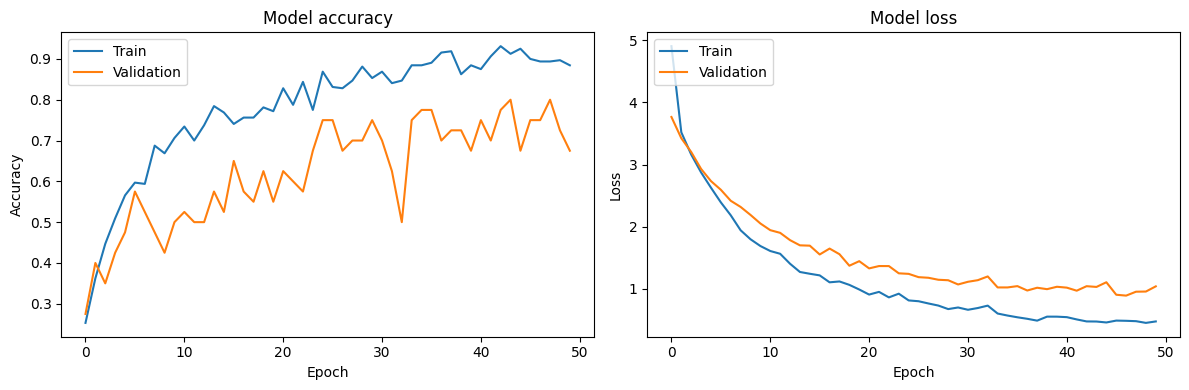

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
model.evaluate(test_images, test_labels_encoded)


2/2 [==============================] - 0s 9ms/step - loss: 1.4639 - accuracy: 0.6250


[1.4638731479644775, 0.625]

# Using Pre-trained Models

In [ ]:
import tensorflow as tf
import os

data_dir = "/content/drive/MyDrive/Colab Notebooks/Hands-On Machine Learning - Aurelien Geron/Chapter 14 - CNN/Vehicle Type Recognition/Dataset"

# Load the model
model = tf.keras.applications.EfficientNetB7(weights="imagenet")

# Load and preprocess images
image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]
images = []
for img_path in X_test:
    loaded_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(600, 600))
    img_array = tf.keras.preprocessing.image.img_to_array(loaded_img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    images.append(img_array)

test_images = np.array(images)

# Predict
y_prob = model.predict(test_images)
print(y_prob.shape)


2/2 [==============================] - 18s 3s/step
(40, 1000)


In [ ]:
top_K = tf.keras.applications.efficientnet.decode_predictions(y_prob, top=3)
for image_index in range(len(images)):
  print(f"Image #{image_index}")
  for class_id, name, y_prob in top_K[image_index]:
    print(f" {class_id} - {name:12s} {y_prob:.2%}")

35363/35363 [==============================] - 0s 0us/step
Image #0
 n03785016 - moped        28.45%
 n03791053 - motor_scooter 26.66%
 n03208938 - disk_brake   12.16%
Image #1
 n03796401 - moving_van   80.58%
 n04467665 - trailer_truck 0.38%
 n04065272 - recreational_vehicle 0.14%
Image #2
 n03791053 - motor_scooter 51.00%
 n03208938 - disk_brake   16.08%
 n03127747 - crash_helmet 2.65%
Image #3
 n03895866 - passenger_car 39.86%
 n04487081 - trolleybus   25.70%
 n03769881 - minibus      5.01%
Image #4
 n04467665 - trailer_truck 66.44%
 n03417042 - garbage_truck 5.62%
 n04461696 - tow_truck    3.87%
Image #5
 n04467665 - trailer_truck 80.90%
 n04461696 - tow_truck    3.52%
 n03345487 - fire_engine  0.35%
Image #6
 n04037443 - racer        33.99%
 n04285008 - sports_car   26.69%
 n03100240 - convertible  9.10%
Image #7
 n03208938 - disk_brake   37.92%
 n03791053 - motor_scooter 31.05%
 n03127747 - crash_helmet 1.32%
Image #8
 n04285008 - sports_car   85.65%
 n04037443 - racer        1.9

# Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def preprocess(data):
    train_images = []
    for dir in data:
        # Load and resize the image
        loaded_img = load_img(dir, target_size=(299, 299))

        # Convert the PIL image to a numpy array
        img_array = img_to_array(loaded_img)

        # Expand the dimensions to fit the expected model input
        img_array = tf.expand_dims(img_array, axis=0)

        # Preprocess the image using Xception's preprocessing function
        img_array = tf.keras.applications.xception.preprocess_input(img_array)

        # Append to the list
        train_images.append(img_array[0])

    return np.array(train_images)

train_images = preprocess(X_train)
valid_images = preprocess(X_valid)
test_images = preprocess(X_test)

# Step 1: Label Encoding
label_encoder = LabelEncoder()
train_labels_int = label_encoder.fit_transform(train_labels)
valid_labels_int = label_encoder.transform(valid_labels)
test_labels_int = label_encoder.transform(test_labels)

# Step 2: One-Hot Encoding
train_labels_encoded = to_categorical(train_labels_int, num_classes=4)
valid_labels_encoded = to_categorical(valid_labels_int, num_classes=4)
test_labels_encoded = to_categorical(test_labels_int, num_classes=4)



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
base_model = Xception(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels_encoded, epochs=50,
                    validation_data=(valid_images, valid_labels_encoded))


Epoch 1/50
10/10 [==============================] - 12s 492ms/step - loss: 0.3328 - accuracy: 0.8625 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 3s 294ms/step - loss: 0.0700 - accuracy: 0.9781 - val_loss: 6.1663e-04 - val_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 3s 332ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 4s 421ms/step - loss: 0.0084 - accuracy: 0.9969 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 3s 347ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 3s 297ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 3s 292ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 7.4571e-04 - val_accuracy: 1.00

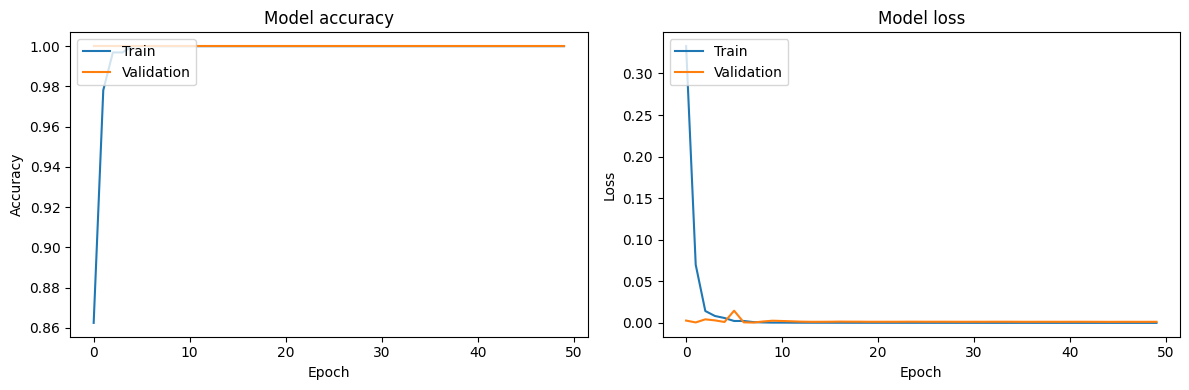

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
model.evaluate(test_images, test_labels_encoded)


2/2 [==============================] - 0s 66ms/step - loss: 0.2027 - accuracy: 0.9750


[0.20274853706359863, 0.9750000238418579]

In [ ]:
model.save("vehicle_recognition_model.h5")
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model("vehicle_recognition_model.h5")

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open("vehicle_recognition_model.tflite", "wb") as f:
    f.write(tflite_model)
